In [136]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

# define els_obs as an object containing x_normals and y_normals with same as size as n_pts
class els_normals:
    def __init__(self, els, n_pts):
        x_normals = els.x_normals
        y_normals = els.y_normals
        x_shears = els.x_shears
        y_shears = els.y_shears

        self.x_normals = np.zeros(n_pts * len(x_normals))
        self.y_normals = np.zeros(n_pts * len(x_normals))
        self.x_normals[0:n_pts] = x_normals[0]
        self.y_normals[0:n_pts] = y_normals[0]
        self.x_normals[n_pts : 2 * n_pts] = x_normals[1]
        self.y_normals[n_pts : 2 * n_pts] = y_normals[1]
        self.x_normals[2 * n_pts :] = x_normals[2]
        self.y_normals[2 * n_pts :] = y_normals[2]

        self.x_shears = np.zeros(n_pts * len(x_normals))
        self.y_shears = np.zeros(n_pts * len(x_normals))
        self.x_shears[0:n_pts] = x_shears[0]
        self.y_shears[0:n_pts] = y_shears[0]
        self.x_shears[n_pts : 2 * n_pts] = x_shears[1]
        self.y_shears[n_pts : 2 * n_pts] = y_shears[1]
        self.x_shears[2 * n_pts :] = x_shears[2]
        self.y_shears[2 * n_pts :] = y_shears[2]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Example 1: Right angle step
Consider a 3-element fault that meets only at right angles, and we impose slip on the node centers.

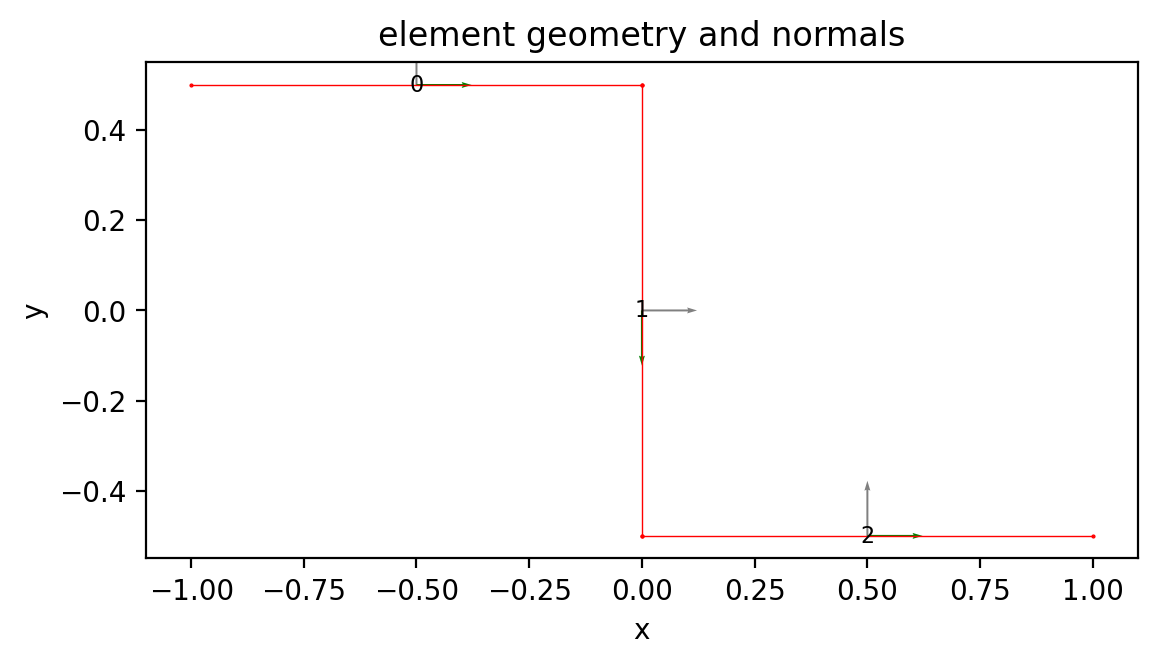

In [137]:
els = bemcs.initialize_els()
els.x1 = np.array([-1.0, 0.0, 0.0])
els.y1 = np.array([0.5, 0.5, -0.5])
els.x2 = np.array([0.0, 0.0, 1.0])
els.y2 = np.array([0.5, -0.5, -0.5])
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)


# Imposed slip (specified in $x,y$ direction)

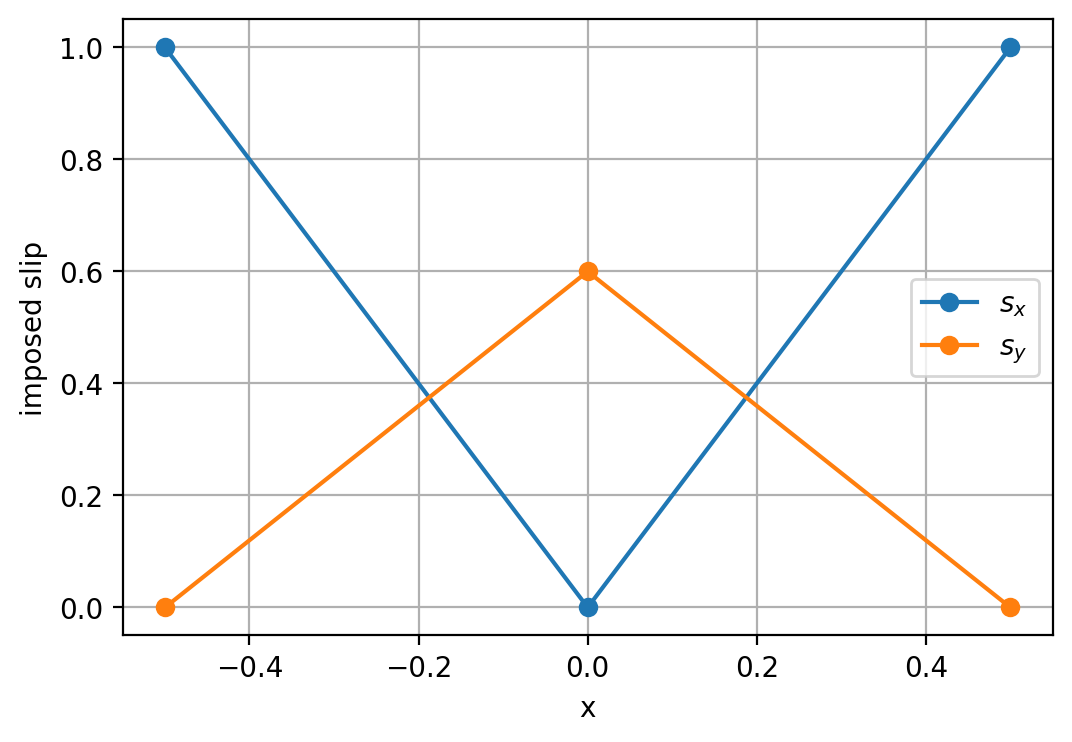

In [138]:
# Slip imposed at central nodes of each patch (these are in x,y coordinates)
slip_vector_x = np.array([1.0, 0.0, 1.0])
slip_vector_y = np.array([0.0, 0.6, 0.0])
# slip_vector_x = np.random.rand(3)
# slip_vector_y = np.random.rand(3)

# Plot slip function
plt.figure(figsize=(6, 4))
plt.plot(els.x_centers, slip_vector_x, "o-", label="$s_x$")
plt.plot(els.x_centers, slip_vector_y, "o-", label="$s_y$")
plt.xlabel("x")
plt.ylabel("imposed slip")
plt.grid()
plt.legend()
plt.show()

In [139]:
# Design matrices (in x, y coordinates) for slip and slip gradients at each 3qn
stride = 6
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(els, flag="node")
design_mat = np.zeros((n_els * stride, n_els * stride))

# Set boundary conditions
# Slip -or- slip gradients at the boundaries (we set them to 0 here)
bc_vec = np.zeros((n_els * stride))
bc_vec[0] = 0.0
bc_vec[1] = 0.0
bc_vec[-1] = 0.0
bc_vec[-2] = 0.0
bc_vec[2::stride] = slip_vector_x
bc_vec[3::stride] = slip_vector_y

# Populate design matrix
# Boundary nodes
design_mat[0:2, :] = slip_mat[0:2]
design_mat[-2:, :] = slip_mat[-2:, :]

# Patch center nodes
design_mat[2::stride, :] = slip_mat[2::stride, :]
design_mat[3::stride, :] = slip_mat[3::stride, :]

# Overlapping interior nodes (apply slip continuity and smoothness)
# Slip continuity (x component)
design_mat[4:-7:stride, :] = slip_mat[4:-7:stride, :] - slip_mat[6:-5:stride, :]

# Slip continuity (x component)
design_mat[5:-6:stride, :] = slip_mat[5:-6:stride, :] - slip_mat[7:-4:stride, :]

# Smoothness
# x component
design_mat[6:-5:stride, :] = (
    slip_gradient_mat[4:-7:stride, :] - slip_gradient_mat[6:-5:stride, :]
)
# y component
design_mat[7:-4:stride, :] = (
    slip_gradient_mat[5:-6:stride, :] - slip_gradient_mat[7:-4:stride, :]
)

# Solve for quadratic node coefficients (in local (s, n) coordinates)
coeffs = np.linalg.inv(design_mat) @ bc_vec

# Extract (s, n) components and store them in two separate vectors
coeffs_s = np.zeros((3 * n_els))
coeffs_n = np.zeros((3 * n_els))
for i in range(n_els):
    coeffs_s[3 * i : 3 * (i + 1)] = coeffs[stride * i : stride * i + 3]
    coeffs_n[3 * i : 3 * (i + 1)] = coeffs[stride * i + 3 : stride * (i + 1)]

# Plot displacements and stresses

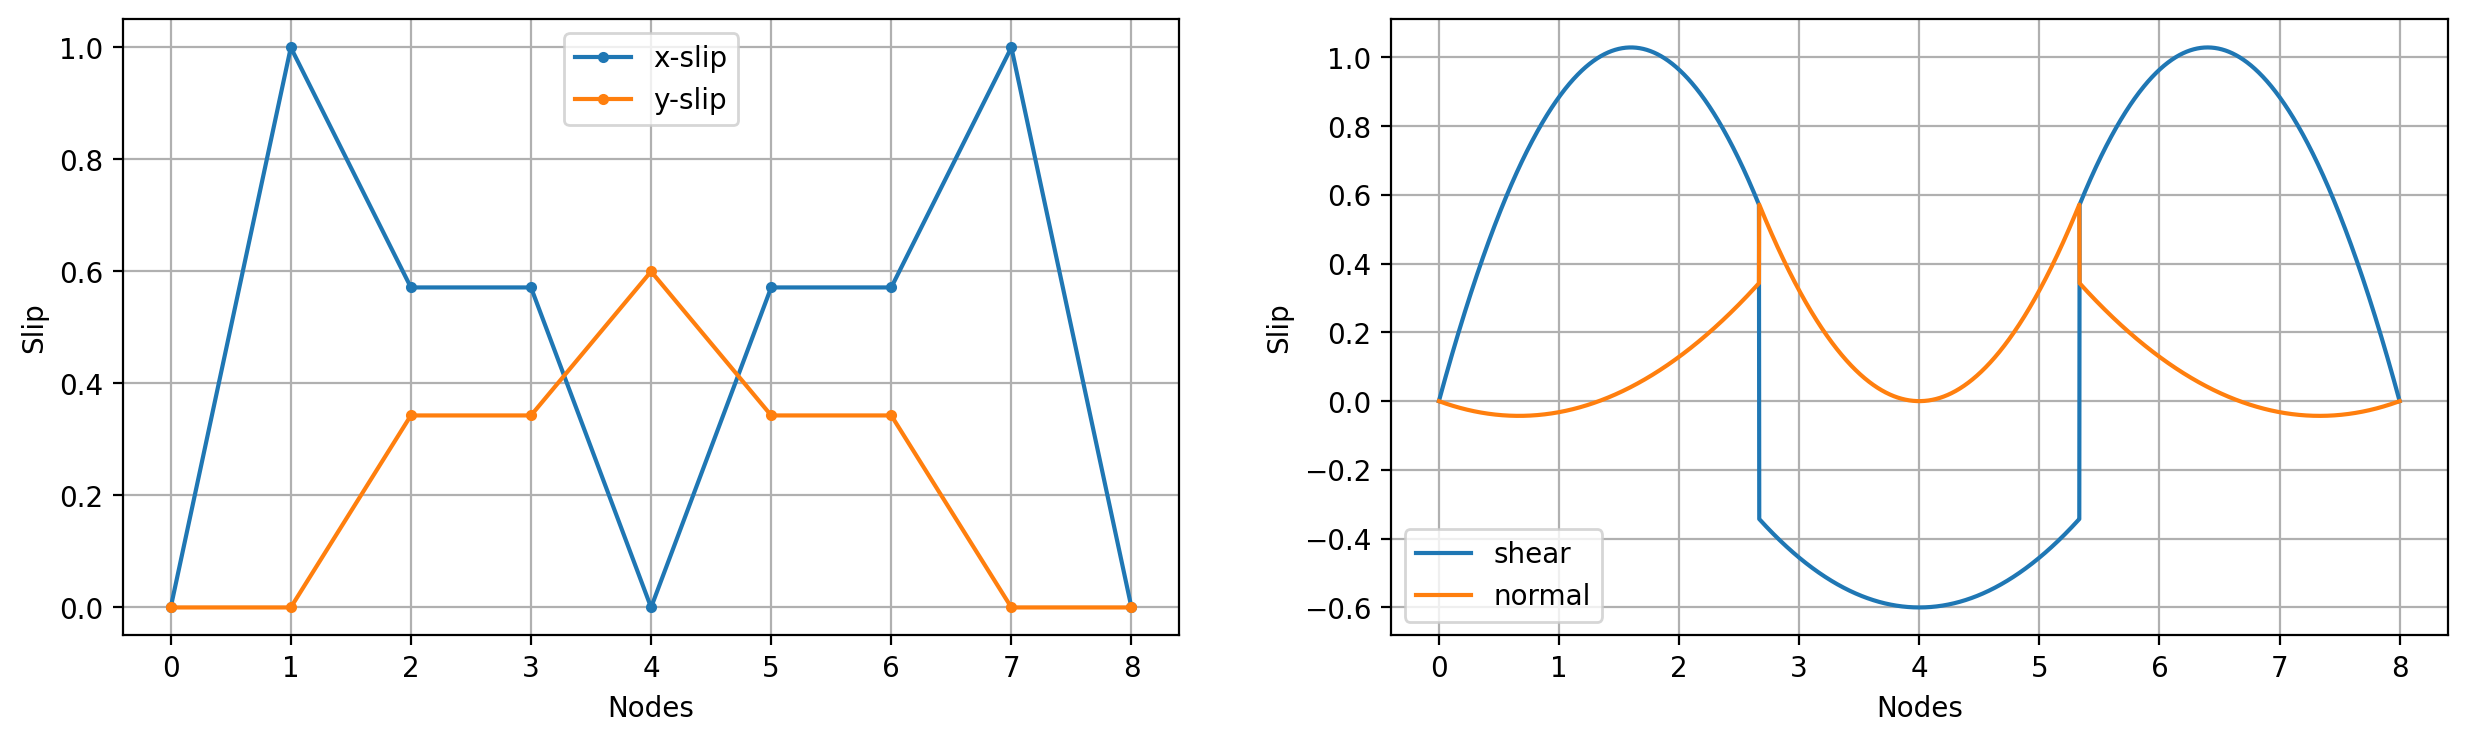

[[ 3.42857143e+00 -3.42857143e-01]
 [ 5.71428571e-01  3.42857143e-01]
 [-2.28571429e+00  1.02857143e+00]
 [-2.28571429e+00  1.02857143e+00]
 [-2.77555756e-16 -5.55111512e-17]
 [ 2.28571429e+00 -1.02857143e+00]
 [ 2.28571429e+00 -1.02857143e+00]
 [-5.71428571e-01 -3.42857143e-01]
 [-3.42857143e+00  3.42857143e-01]]


In [140]:
n_eval = 1000
fault_slip_s = np.zeros(n_els * n_eval)
fault_slip_n = np.zeros(n_els * n_eval)
for i in range(n_els):
    xdummy = np.linspace(-0.5, 0.5, n_eval)
    fault_slip_s[i * n_eval : (i + 1) * n_eval] = (
        bemcs.slip_functions(xdummy, 0.5) @ coeffs_s[3 * i : 3 * (i + 1)]
    )
    fault_slip_n[i * n_eval : (i + 1) * n_eval] = (
        bemcs.slip_functions(xdummy, 0.5) @ coeffs_n[3 * i : 3 * (i + 1)]
    )

# x_nodes = np.zeros((3 * n_els, 1))
# x_nodes[0::3, 0] = els.x1
# x_nodes[2::3, 0] = els.x2
# x_nodes[1::3, 0] = els.x_centers
fault_slip = slip_mat @ coeffs
fault_slip_x = fault_slip[0::2]
fault_slip_y = fault_slip[1::2]
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(fault_slip_x, ".-", label="x-slip")
plt.plot(fault_slip_y, ".-", label="y-slip")
plt.grid()
plt.legend()
plt.xlabel("Nodes")
plt.ylabel("Slip")
plt.subplot(1, 2, 2)
plt.plot(
    np.linspace(0, 3 * n_els - 1, n_els * n_eval), fault_slip_s, "-", label="shear"
)
plt.plot(
    np.linspace(0, 3 * n_els - 1, n_els * n_eval), fault_slip_n, "-", label="normal"
)
plt.grid()
plt.legend()
plt.xlabel("Nodes")
plt.ylabel("Slip")
plt.show()

print(
    np.hstack(
        (
            (slip_gradient_mat @ coeffs).reshape(-1, 1)[0::2],
            (slip_gradient_mat @ coeffs).reshape(-1, 1)[1::2],
        )
    )
)

### Compute tractions along elements

Testing to see if tractions are continuous along the fault

Plot displacements and stresses on both sides of the fault

In [141]:
# Compute displacement and stress kernels
# Elastic parameters
mu = 1
nu = 0.25

# Compute displacements along a line
n_pts = 1000
dr = 1e-8
els_obs = els_normals(els, n_pts)

x_obs_p = np.hstack(
    (
        np.linspace(els.x1[0], els.x2[0], n_pts) + dr * els.x_normals[0],
        np.linspace(els.x1[1], els.x2[1], n_pts) + dr * els.x_normals[1],
        np.linspace(els.x1[2], els.x2[2], n_pts) + dr * els.x_normals[2],
    )
).reshape(-1, 1)
y_obs_p = np.hstack(
    (
        np.linspace(els.y1[0], els.y2[0], n_pts) + dr * els.y_normals[0],
        np.linspace(els.y1[1], els.y2[1], n_pts) + dr * els.y_normals[1],
        np.linspace(els.y1[2], els.y2[2], n_pts) + dr * els.y_normals[2],
    )
).reshape(-1, 1)

x_obs_n = np.hstack(
    (
        np.linspace(els.x1[0], els.x2[0], n_pts) - dr * els.x_normals[0],
        np.linspace(els.x1[1], els.x2[1], n_pts) - dr * els.x_normals[1],
        np.linspace(els.x1[2], els.x2[2], n_pts) - dr * els.x_normals[2],
    )
).reshape(-1, 1)
y_obs_n = np.hstack(
    (
        np.linspace(els.y1[0], els.y2[0], n_pts) - dr * els.y_normals[0],
        np.linspace(els.y1[1], els.y2[1], n_pts) - dr * els.y_normals[1],
        np.linspace(els.y1[2], els.y2[2], n_pts) - dr * els.y_normals[2],
    )
).reshape(-1, 1)

# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs_p, y_obs_p, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs_p, y_obs_p, els, mu, nu, flag="normal"
)

# compute traction kernels
tractionkernels_s = bemcs.get_traction_kernels(els_obs, kernels_s, flag="global")
tractionkernels_n = bemcs.get_traction_kernels(els_obs, kernels_n, flag="global")

# displacements and stresses
ux_p, uy_p, sxx_p, syy_p, sxy_p = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)
# tractions
tx_p = tractionkernels_s[0] @ coeffs_s + tractionkernels_n[0] @ coeffs_n
ty_p = tractionkernels_s[1] @ coeffs_s + tractionkernels_n[1] @ coeffs_n


# Compute shear and tensile stress kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs_n, y_obs_n, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs_n, y_obs_n, els, mu, nu, flag="normal"
)

# compute traction kernels
tractionkernels_s = bemcs.get_traction_kernels(els_obs, kernels_s, flag="global")
tractionkernels_n = bemcs.get_traction_kernels(els_obs, kernels_n, flag="global")

# displacements and stresses
ux_n, uy_n, sxx_n, syy_n, sxy_n = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)
# tractions
tx_n = tractionkernels_s[0] @ coeffs_s + tractionkernels_n[0] @ coeffs_n
ty_n = tractionkernels_s[1] @ coeffs_s + tractionkernels_n[1] @ coeffs_n

# Plot results

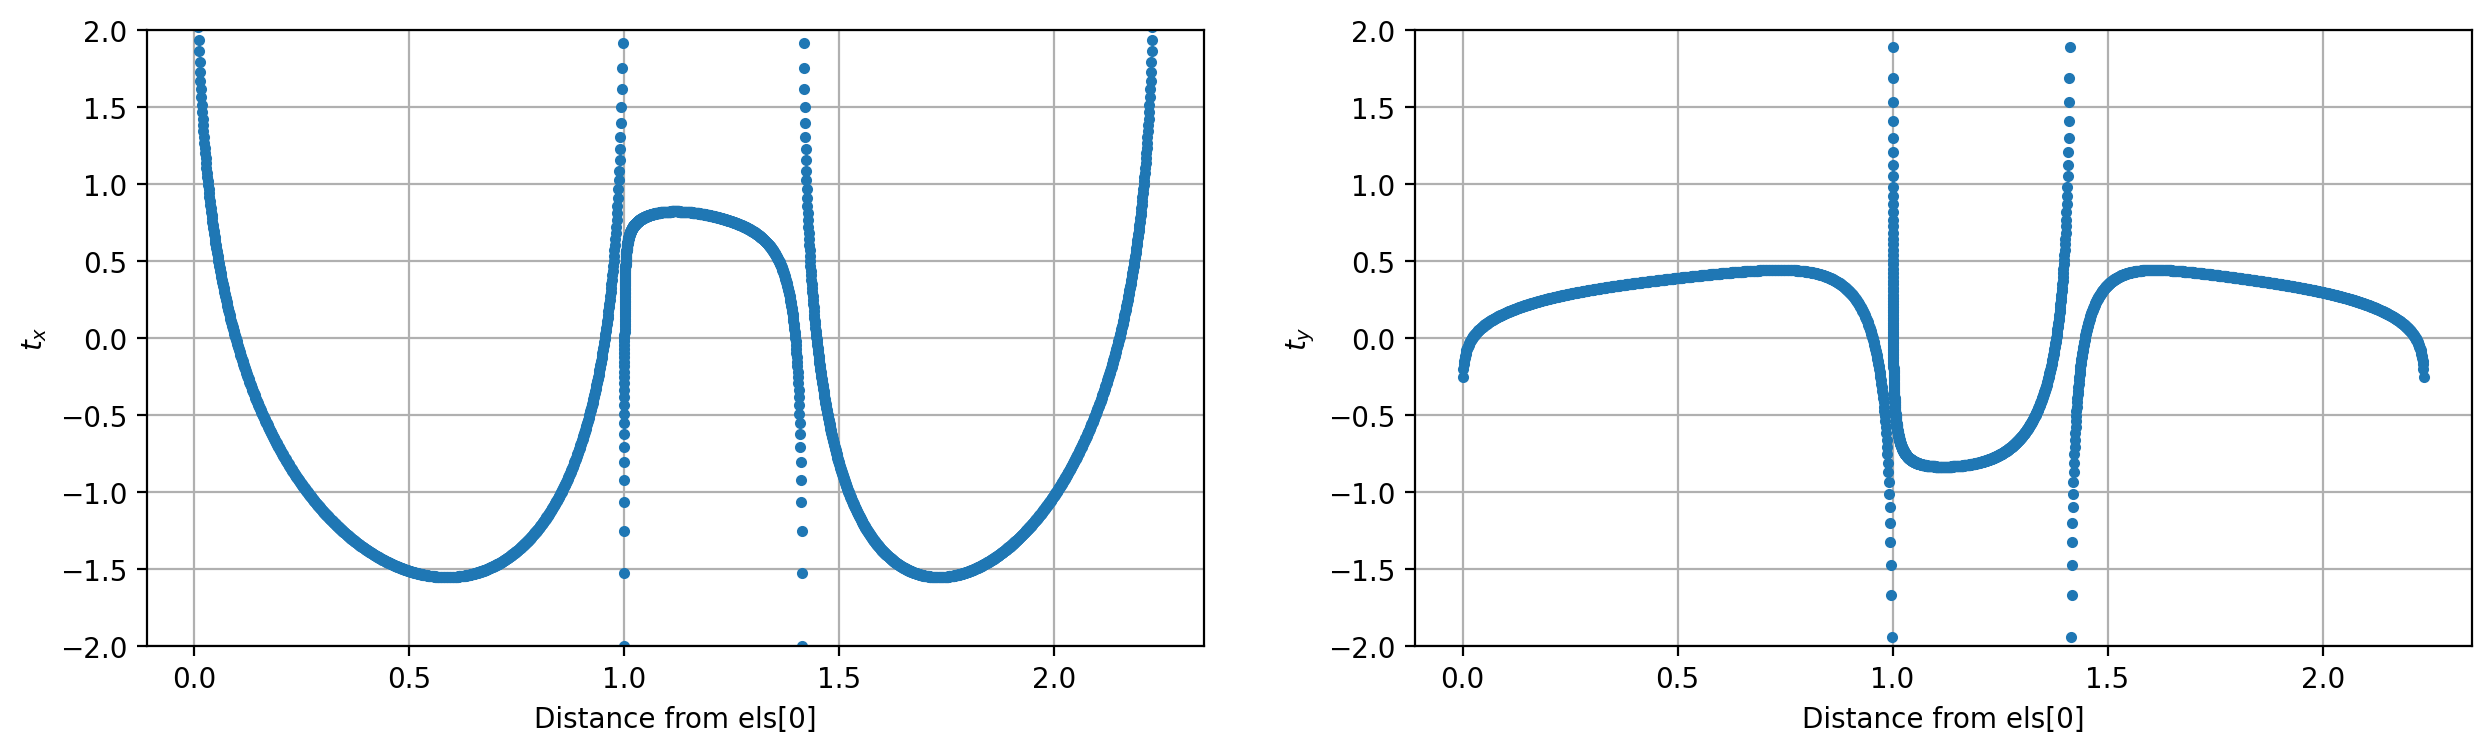

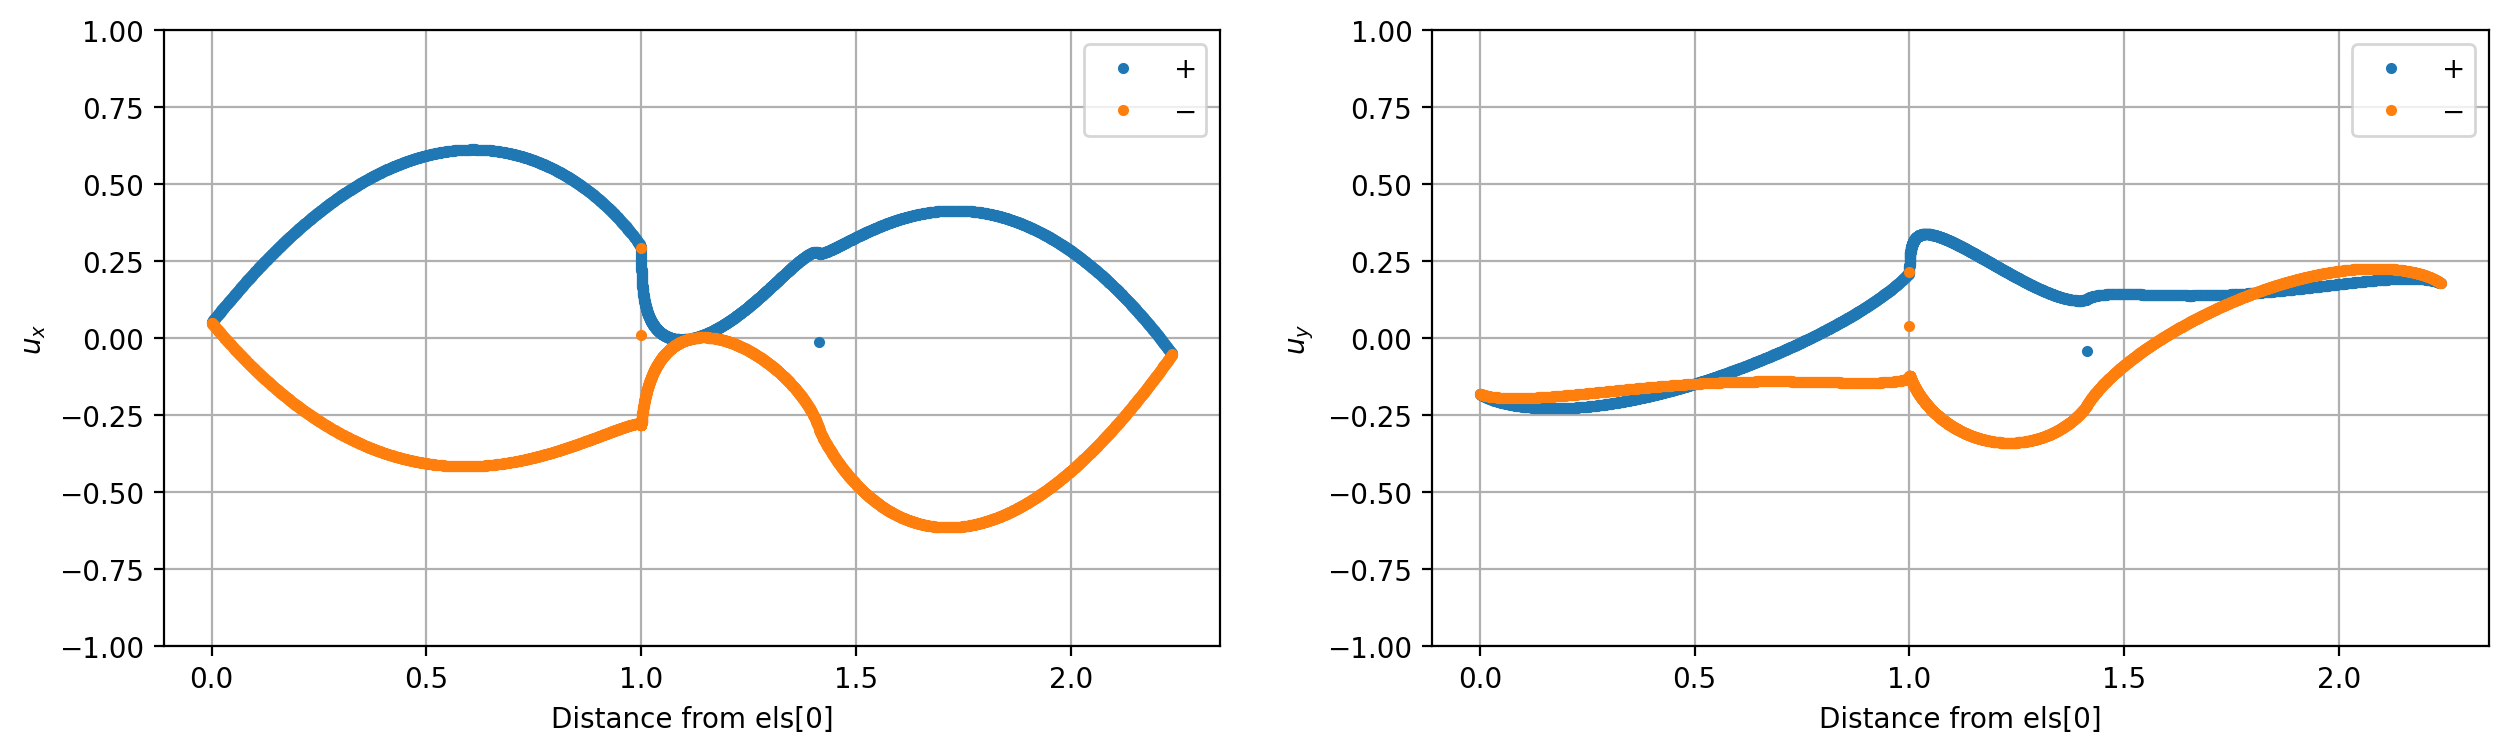

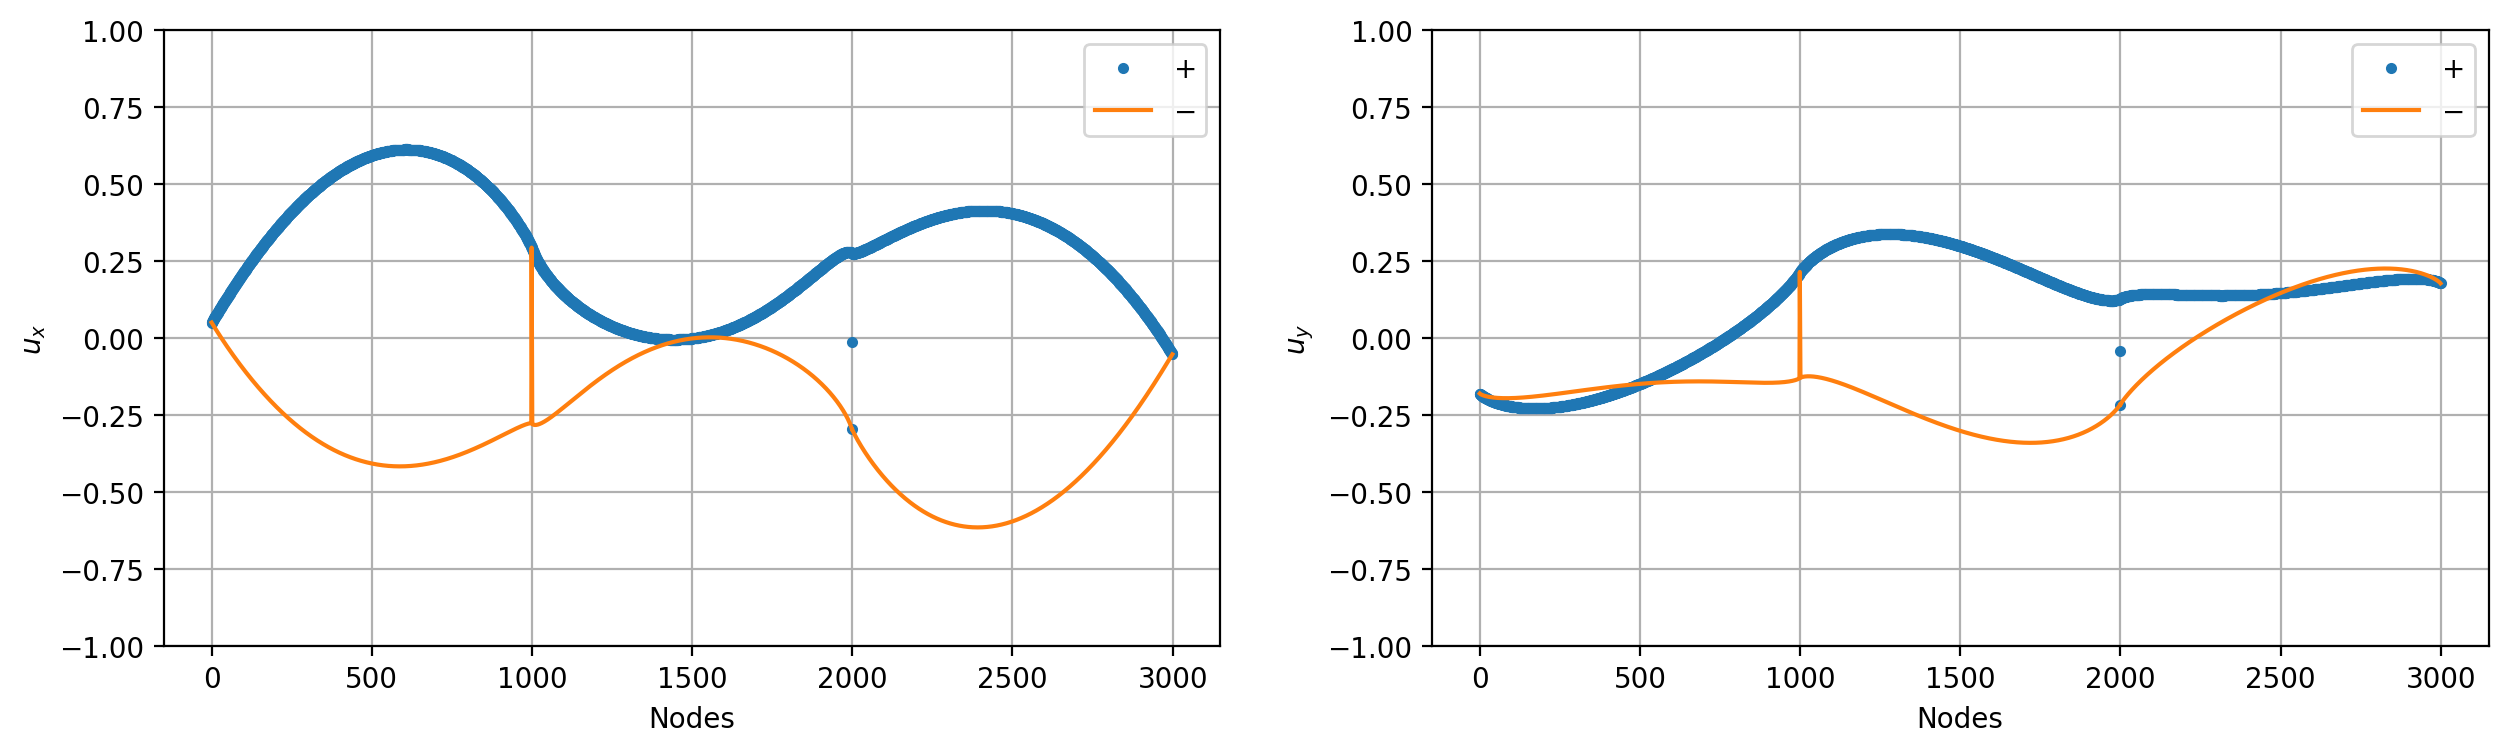

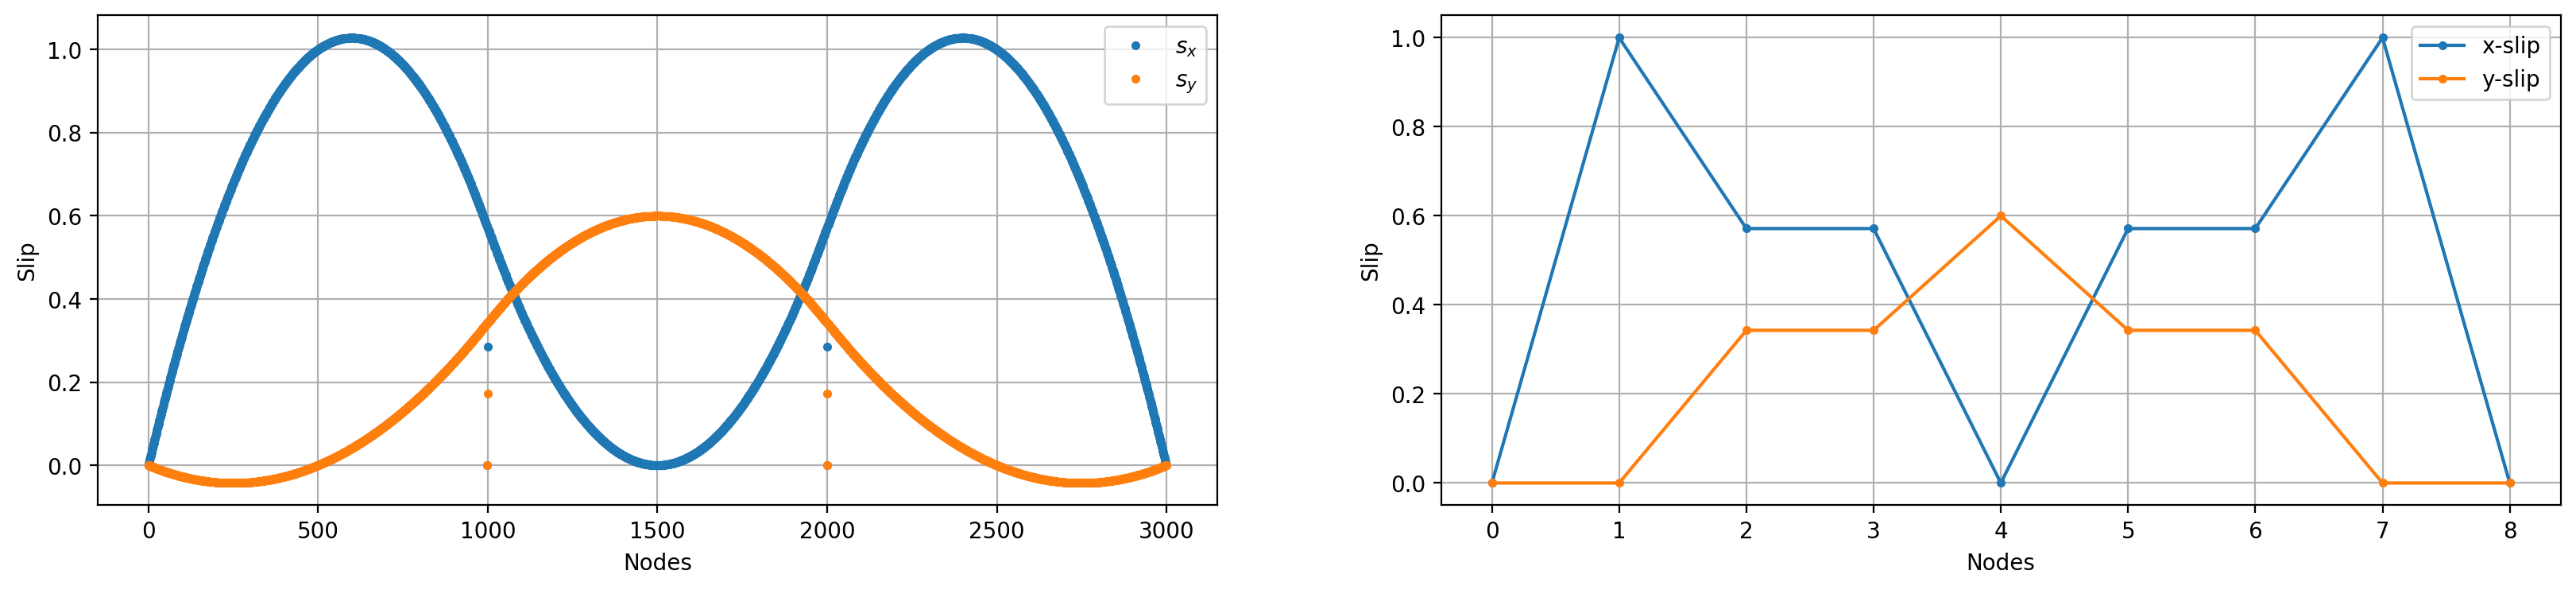

In [142]:
r = np.sqrt((x_obs_p - els.x1[0]) ** 2 + (y_obs_p - els.y1[0]) ** 2)
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(r, tx_p, ".")
plt.grid()
plt.xlabel("Distance from els[0]")
plt.ylabel("$t_x$")
plt.ylim(-2, 2)
plt.subplot(1, 2, 2)
plt.plot(r, ty_p, ".")
plt.grid()
plt.xlabel("Distance from els[0]")
plt.ylabel("$t_y$")
plt.ylim(-2, 2)
plt.show()

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(r, ux_p, ".", label="$+$")
plt.plot(r, ux_n, ".", label="$-$")
plt.grid()
plt.legend()
plt.ylim(-1, 1)
plt.xlabel("Distance from els[0]")
plt.ylabel("$u_x$")
plt.subplot(1, 2, 2)
plt.plot(r, uy_p, ".", label="$+$")
plt.plot(r, uy_n, ".", label="$-$")
plt.grid()
plt.legend()
plt.ylim(-1, 1)
plt.xlabel("Distance from els[0]")
plt.ylabel("$u_y$")
plt.show()

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(ux_p, ".", label="$+$")
plt.plot(ux_n, "-", label="$-$")
plt.grid()
plt.legend()
plt.ylim(-1, 1)
plt.xlabel("Nodes")
plt.ylabel("$u_x$")
plt.subplot(1, 2, 2)
plt.plot(uy_p, ".", label="$+$")
plt.plot(uy_n, "-", label="$-$")
plt.grid()
plt.legend()
plt.ylim(-1, 1)
plt.xlabel("Nodes")
plt.ylabel("$u_y$")
plt.show()

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(ux_p - ux_n, ".", label="$s_x$")
plt.plot(uy_p - uy_n, ".", label="$s_y$")
plt.grid()
plt.legend()
plt.xlabel("Nodes")
plt.ylabel("Slip")
plt.subplot(1, 2, 2)
# plt.plot(fault_slip_s, "-", label="shear")
# plt.plot(fault_slip_n, "-", label="normal")
plt.plot(fault_slip_x, ".-", label="x-slip")
plt.plot(fault_slip_y, ".-", label="y-slip")
plt.grid()
plt.legend()
plt.xlabel("Nodes")
plt.ylabel("Slip")
plt.show()